<a href="https://colab.research.google.com/github/jdclifton2/researchCode/blob/master/Function_Timing_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Testing Function Runtime for Bipartite Graphs Improved 

> "Timing two functions to see which is faster."

- toc:false
- branch: master
- badges: true
- comments: true
- author: JC
- categories: [networkx, graphs, unit testing, timeit, python]

In [1]:
import networkx as nx
from typing import Dict, Tuple, List
import numpy as np
from numpy.random import geometric
import timeit
from random import randrange, randint
import pandas as pd

The goal of this notebook is to compare the speed of functions designed to find all neighbors within distance 3 of a given vertex. The current function on the gitcoin repository utilizes a generate and filter methodology. We propose that the ego_graph() function in networkx is superior for large bipartite graphs. We will now offer justification for this proposal by using simulations and the timeit library.

#### The current function in the github repo.

In [3]:
def robust_shortest_path_length(*args, **kwargs) -> float:
    output = np.inf
    try:
        output = nx.shortest_path_length(*args, **kwargs)
    finally:
        return output

def NeighborsSubgraph(contribution_graph: nx.Graph, grant: str) -> nx.Graph:
    """"""
    source = grant
    distances_to_source = {
        target: robust_shortest_path_length(contribution_graph, source, target)
        for target in contribution_graph.nodes
    }

    neighbors = [
        node for (node, distance) in distances_to_source.items() if distance <= 3
    ]

    neighbors_subgraph = contribution_graph.subgraph(neighbors)
    return neighbors_subgraph

#### Proposed function

In [22]:
def Neighbors(contribution_graph: nx.Graph, grant: str) -> nx.Graph:
    """
    This function takes in a graph of contributions (contribution_graph) and a 
    grant that corresponds to a vertex within the contribution graph.
    Using this information, the function finds all neighbors within distance 3
    of the grant. 

    :param contribution_graph: A bipartite graph of contributors and the projects
    they are contributing to.

    :param grant: A grant contained within the contribution graph. Used as the
    starting vertex.

    :return: A subgraph of contribution_graph containing all vertices within
    distance 3 of grant. 
    """
    return nx.ego_graph(contribution_graph, grant, radius=3)


The relationship between donators and projects can be modeled as a bipartite graph. Therefore, bipartite graphs will be the structure that this function acts upon and will need to be the most optimized case. A bipartite graph, also called a bigraph, is a set of graph vertices decomposed into two disjoint sets such that no two graph vertices within the same set are adjacent. We will now write a class that will act as a simulation case. The constructor create a random bipartite graph using this definition.

In [5]:
class FundingSimulation:

  def __init__(self, num_funders, num_grants, edge_prob = .35):
    """
    This class represents a simulation of a quadratic funding situation. 
    
    :param num_funders: The number of desired funders.
    :param num_grants: The number of desired grants.
    :param edge_prob: Probability of success for a geometric dist. This 
    determines the number of edges that verticies in the graph will have. In 
    general, a higher probability will mean a higher chance of success in the
    geometric dist and therefore, less edges in the graph. 
    :return: A bipartite graph with random edges.
    """

    #create two disjoin sets
    self.funders = set(range(0, num_funders))
    self.grants = set(range(num_funders, num_funders + num_grants))
    
    bipart = nx.Graph()
    
    bipart.add_nodes_from(self.funders, bipartite=0)
    bipart.add_nodes_from(self.grants, bipartite=1)
    
    
    for vert_a in self.funders:
        
        #the number of edges a specific vertex will have
        num_edges = geometric(p=edge_prob)
        
        for edge in range(num_edges):
            #pick a random vertex from set_b
            vert_b = randrange(num_funders, num_funders + num_grants)
            bipart.add_edge(vert_a, vert_b)
        
    self.bipart = bipart

In [6]:
def create_simulations(num_sims = 50, max_funders = 20, min_funders = 1, max_grants = 20, min_grants = 1, min_entries = 1, edge_prob=.35):
    """
    This function creates a suite of random quadratic funding simulations.
    :param num_sims: The number of simulations to generate.
    :param max_funders: The maximum number of funders any sim in the suite can have.
    :param min_funders: The minimum number of funders any sim in the suite can have.
    :param max_grants: The maximum number of grants any sim in the suite can have.
    :param min_grants: The minimum number of grants any sim in the suite can have.
    :param min_entries: The minimum number of simulations performed.
    :param edge_prob: Probability of success for a geometric dist. This 
    determines the number of edges that verticies in the graph will have. In 
    general, a higher probability will mean a higher chance of success in the
    geometric dist and therefore, less edges in the graph. 
    
    :return: An array of random simulations. 
    """
    simulations = []
    for i in range(min_entries, num_sims + 1):

        num_funders = randint(min_funders, max_funders)

        num_grants = randint(min_grants, max_grants)

        simulation = FundingSimulation(num_funders, num_grants, edge_prob)
        simulations.append(simulation)
    
    return np.array(simulations, dtype=object)
    
    

In [ ]:
simulations = create_simulations(num_sims = 500, max_funders = 30)

In [7]:
def create_times_df(simulations):
    """
    This function takes in a list of quadratic funding simulations and applys
    two different functions to each simulation case. This function then times
    how long each function took using timeit and records these results as well 
    as details about the simulation case in a dataframe object. 
    :param simulations: A list of simulations that will be passed to the
    functions. 
    
    :return: A dataframe containing details about the specific simulation as well
    as how long each function took on that specific simulation case.  
    """
    
    #df = pd.DataFrame(columns=["original_func_time", "new_func_time" , "num_edges", "num_verticies"])
    df = pd.DataFrame(columns=["original_func_time", "new_func_time" , "num_funders", "num_grants", "num_edges", "num_verticies", 
                               'start_vert'])
    for simulation in simulations:

        start_vert = randrange(0, len(simulation.grants))

        
        #closure is needed for the timeit library to work
        def func1():
            
            def closure():
                return NeighborsSubgraph(simulation.bipart, start_vert)
    
            t1 = timeit.timeit(closure, number=100)
            return t1
        
        def func2():
            
            def closure2():
                return Neighbors(simulation.bipart, start_vert)
    
            t2 = timeit.timeit(closure2, number=100)
        
            return t2

        num_verticies = len(simulation.bipart)
        num_edges = simulation.bipart.number_of_edges()
        #set_a,set_b = bipartite.sets(graph)
        num_funders = len(simulation.funders)
        num_grants = len(simulation.grants)
        series = {
            "original_func_time": func1(),
            "new_func_time":  func2(),
            "num_funders": num_funders,
            "num_grants": num_grants,
            "num_edges": num_edges,
            "num_verticies": num_verticies,
            "start_vert": start_vert,
        }
        df = df.append(series, ignore_index=True)
    return df





In [ ]:
df = create_times_df(simulations)

An example of how the dataframe looks.

In [ ]:
df.head()

,original_func_time,new_func_time,num_funders,num_grants,num_edges,num_verticies,start_vert
0,0.037120,0.015987,7.0,16.0,18.0,23.0,7.0
1,0.020039,0.059313,13.0,12.0,42.0,25.0,7.0
2,0.023900,0.035350,21.0,3.0,33.0,24.0,1.0
3,0.042566,0.063623,23.0,19.0,60.0,42.0,18.0
4,0.031808,0.070712,28.0,5.0,64.0,33.0,2.0


# Comparing the results using plots. 

## Test Suite 1

First we will write a function that will create the plots we need to compare the algorithms.

In [ ]:
from matplotlib import pyplot

def create_plots(df):
  """
  Creates a set of plots for run times of two functions when those functions
  are applied to specific simulations.

  :param df: The dataframe to create plots for.
  """


  pyplot.figure(figsize=(20,20))

  pyplot.subplot(3, 2, 1)
  pyplot.hist(df['original_func_time'], bins = 40, label='original function')
  pyplot.hist(df['new_func_time'], bins = 40, label='new function')
  pyplot.legend(loc='upper right')
  pyplot.title('Function Runtime Comparison')
  pyplot.xlabel('Function Runtime')
  pyplot.ylabel('frequency')

  
  pyplot.subplot(3, 2, 2)
  pyplot.hist(df['new_func_time'], bins = 40, label='new function', color = 'orange')
  pyplot.hist(df['original_func_time'], bins = 40, label='original function', color = 'blue')
  pyplot.legend(loc='upper right')
  pyplot.title('Function Runtime Comparison')
  pyplot.xlabel('Function Runtime')
  pyplot.ylabel('frequency')


  pyplot.subplot(3, 2, 3)
  x = df['num_edges']
  y = df['new_func_time']
  pyplot.scatter(x, y, c='orange', label = "new time", marker='x')
  pyplot.title("Runtime vs Graph Size")
  pyplot.xlabel("Size")
  pyplot.ylabel("Runtime")



  #pyplot.subplot(3, 2, 4)

  x = df['num_edges']
  y = df['original_func_time']
  pyplot.scatter(x, y, c='b', label="original time")
  pyplot.legend(loc='upper left')


  pyplot.subplot(3, 2, 4)

  x = df['num_funders']
  y = df['original_func_time']
  pyplot.scatter(x,y)
  pyplot.title("Original Runtime vs Number of Funders")
  pyplot.xlabel("num funders")
  pyplot.ylabel("Original Runtime")

  pyplot.subplot(3, 2, 5)

  x = df['num_funders']
  y = df['new_func_time']
  pyplot.scatter(x,y)
  pyplot.title("New Runtime vs Number of Funders")
  pyplot.xlabel("num funders")
  pyplot.ylabel("New Runtime")


# Types of plots

### Histograms

For each set of simulations, we will be producing 5 different graphs. The first two graphs are histograms. These two histograms display the same information. The first one is highlighting the distribution of the new function and the second is focused on the distribution of the original function. The x axis is the time it took for the function to run and the y axis is the number of functions that ran within the time displayed on the x axis.

### Scatter plot of run time and graph size

In this graph, the x axis is given by the size of the graph and the y axis is how long the function took to run. An orange x corresponds with the run time of the proposed function and a blue circle indicates the run time of the current function.

### Scatter plot of run time and number of funders

These scatter plots use the number of funders for a given simulation as the x axis and the time that it took to run on the y axis. The first plot is for the current function and the second is for the proposed function.

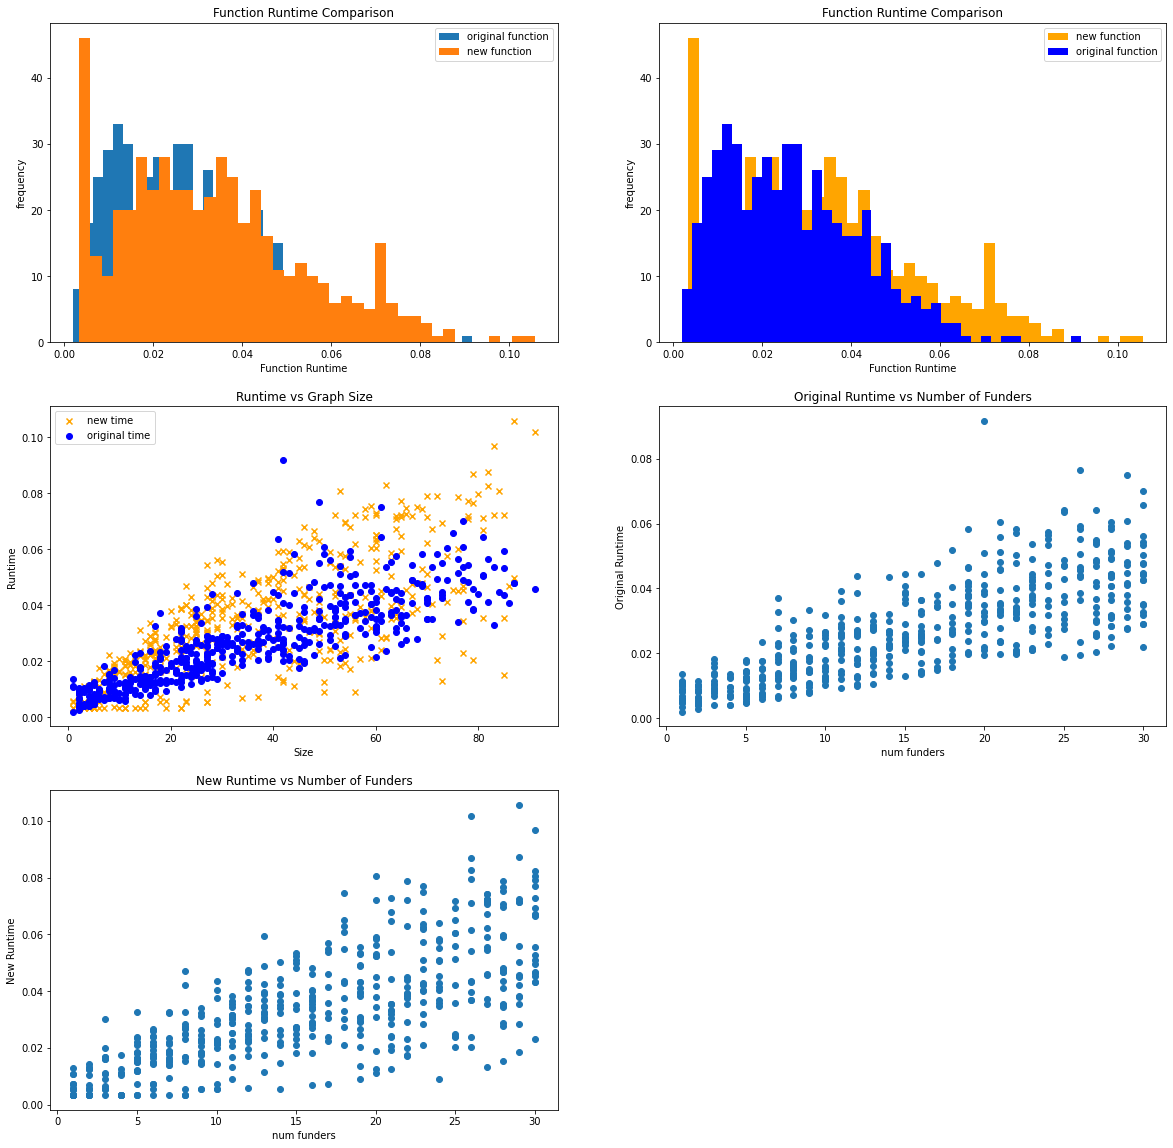

In [ ]:
create_plots(df)

In [ ]:
df.head()

,original_func_time,new_func_time,num_funders,num_grants,num_edges,num_verticies,start_vert
0,0.037120,0.015987,7.0,16.0,18.0,23.0,7.0
1,0.020039,0.059313,13.0,12.0,42.0,25.0,7.0
2,0.023900,0.035350,21.0,3.0,33.0,24.0,1.0
3,0.042566,0.063623,23.0,19.0,60.0,42.0,18.0
4,0.031808,0.070712,28.0,5.0,64.0,33.0,2.0


## Test Suite 2

In this test suite, we will have 500 enteries. Each simulation will have between 20-400 funders and 1-20 grants.

In [ ]:
simulations = create_simulations(num_sims = 500, max_funders= 400, min_funders=20)
df2 = create_times_df(simulations)


In [ ]:
df2.to_csv('./simulations2.csv') 

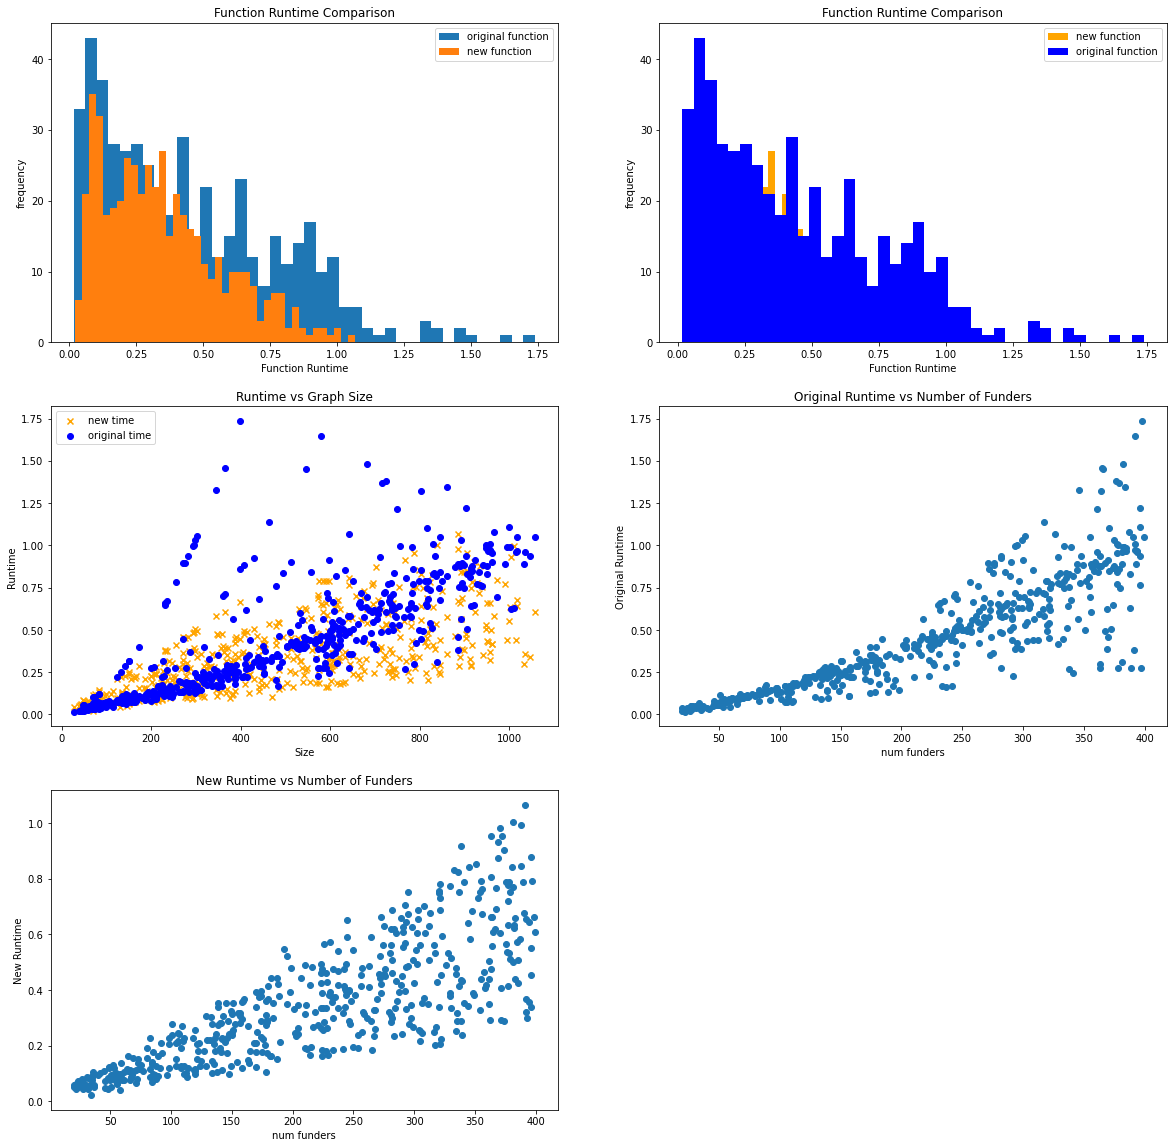

In [ ]:
create_plots(df2)

In this case, it can be seen that the two functions are roughly equivalent.

## Test Suite 3

In this test suite, we will have 500 enteries. Each simulation will have between 20-300 funders and 20-100 grants.

In [ ]:
simulations = create_simulations(num_sims = 500, max_funders= 300, min_funders=20, max_grants=100, min_grants=20)
df3 = create_times_df(simulations)
df3.to_csv('simulations3.csv') 

In [ ]:
df3.to_csv('./simulations3.csv') 

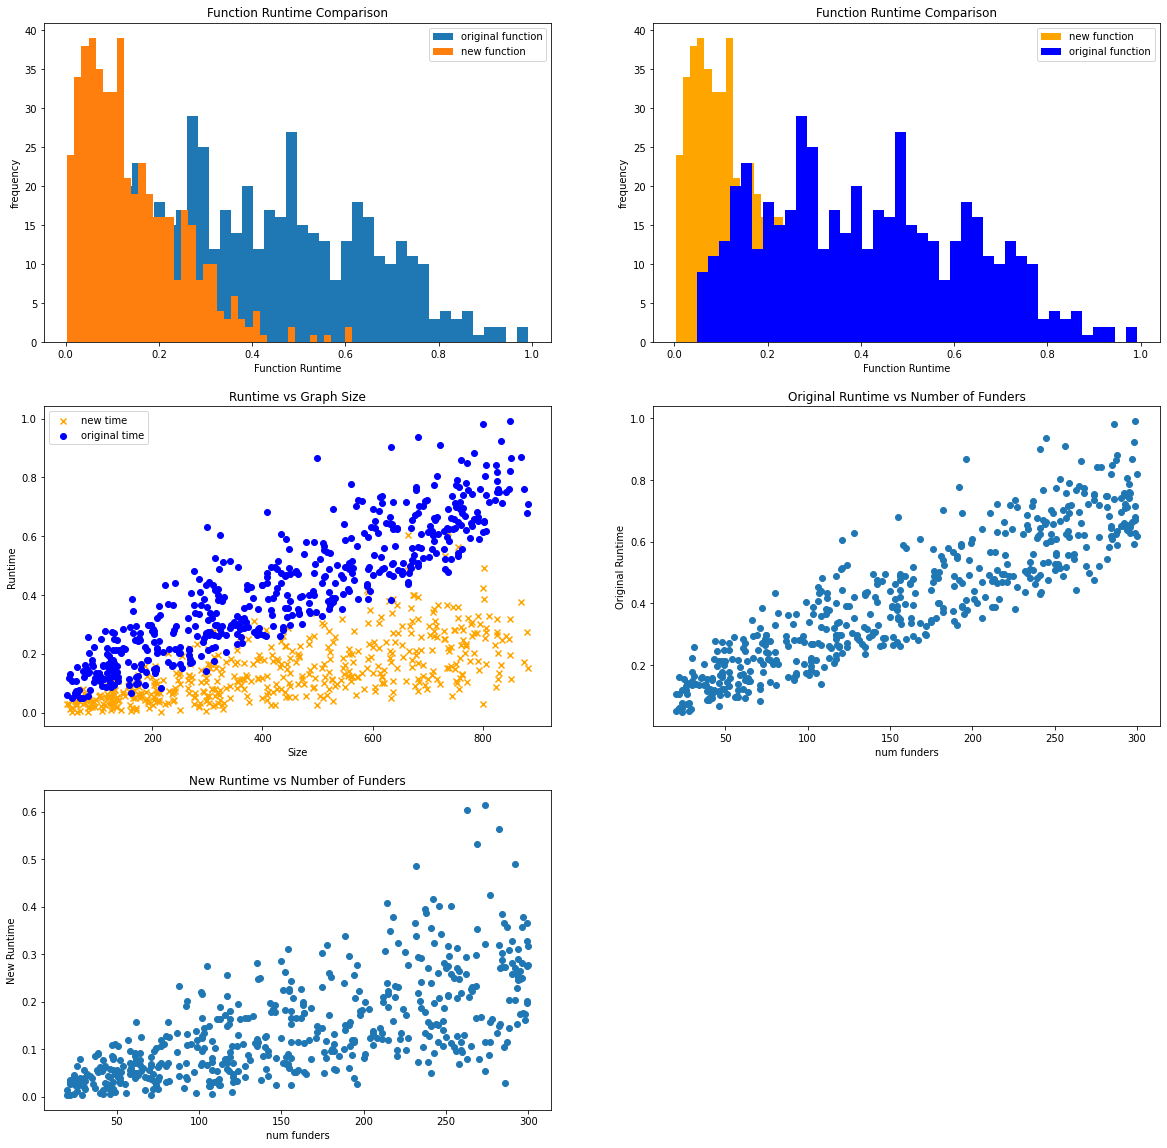

In [ ]:
create_plots(df3)

It can be seen that for this simulation set, the new function has lower run times in general. 

## Test Suite 4

In this test suite, we will have 500 enteries. Each simulation will have between 400-1000 funders and 20-100 grants.

In [ ]:
simulations = create_simulations(num_sims = 500, max_funders= 1000, min_funders=400, max_grants=100, min_grants=20)
df4 = create_times_df(simulations)

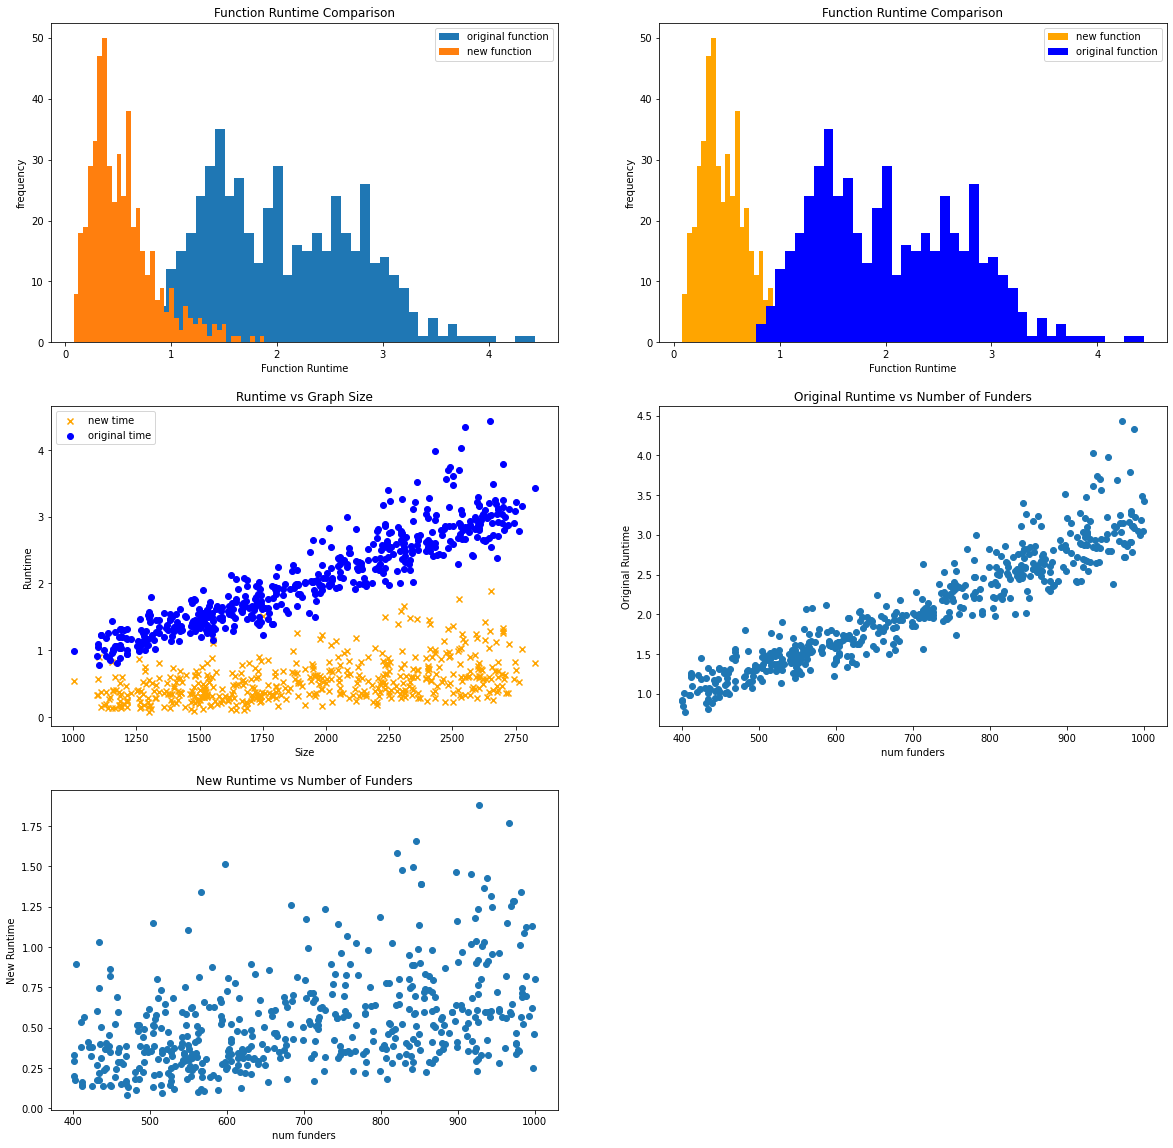

In [ ]:
create_plots(df4)

As we start getting to more realistic simulation cases (large amounts of funders), the new function begins to become much faster than the current function.

## Test Suite 5

In this test suite, we will have 500 enteries. Each simulation will have between 400-2000 funders and 100-400 grants.

In [ ]:
simulations = create_simulations(num_sims = 500, max_funders= 2000, min_funders=400, max_grants=400, min_grants=100)
df5 = create_times_df(simulations)

In [ ]:
df5.to_csv('./simulations5.csv') 

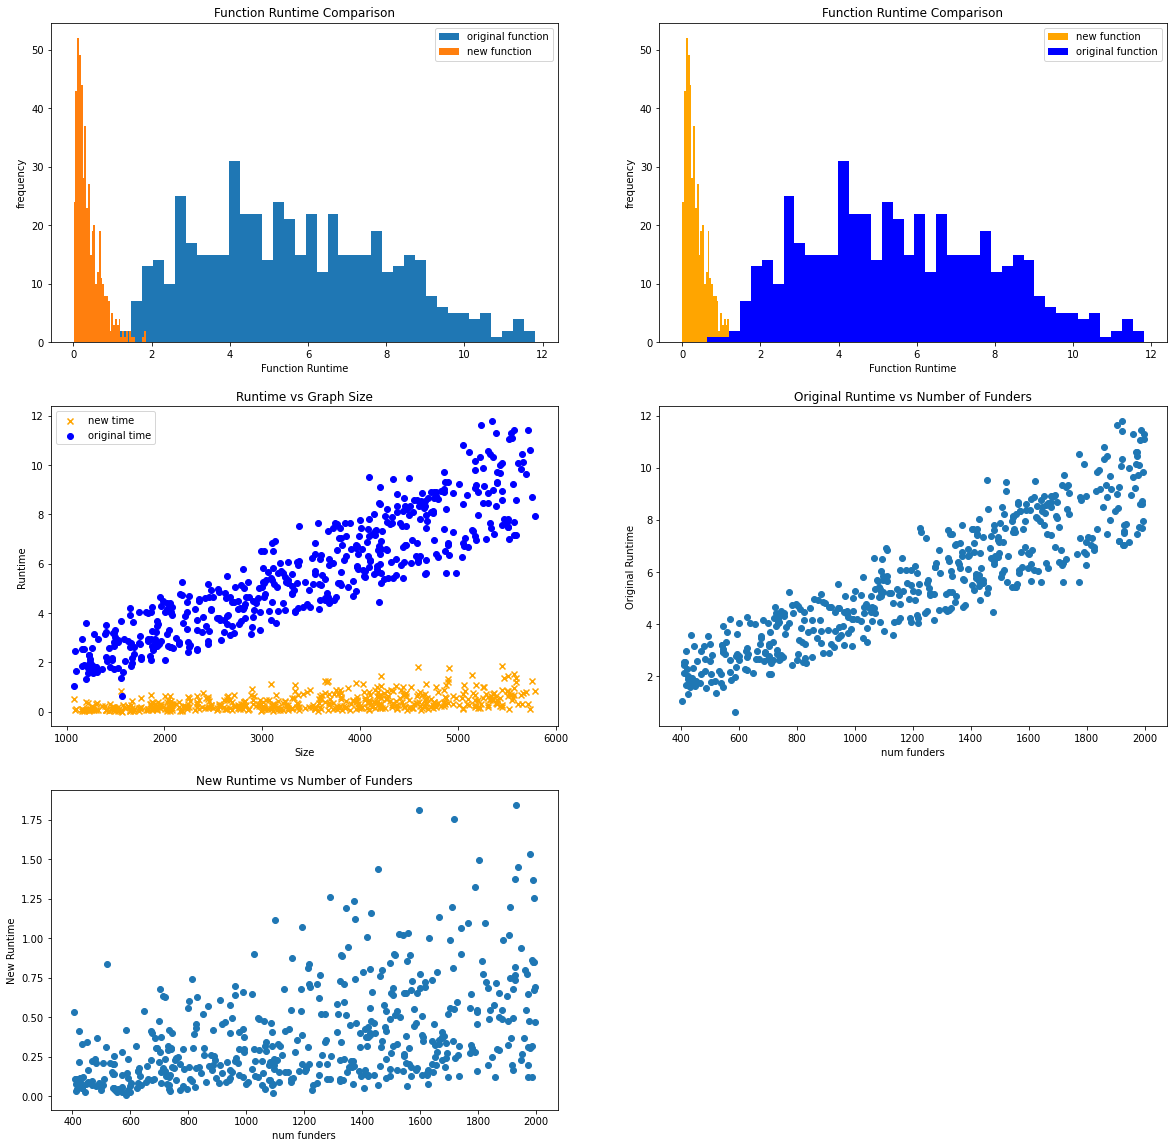

In [ ]:
create_plots(df5)

This simulation set highlights the clear difference between the two functions. In this case, the longest run time for the new function was 2 seconds, and the largest for the original function was almost 12 seconds. 

## Test Suite 6

Now, let us consider the case where a simulation has more grants than funders. In this test suite, we will have 500 enteries. Each simulation will have between 30-100 funders and 200-300 grants.

In [ ]:
simulations = create_simulations(num_sims = 500, max_funders= 100, min_funders=30, max_grants=300, min_grants=200)
df6 = create_times_df(simulations)

In [ ]:
df6.to_csv('./simulations6.csv') 

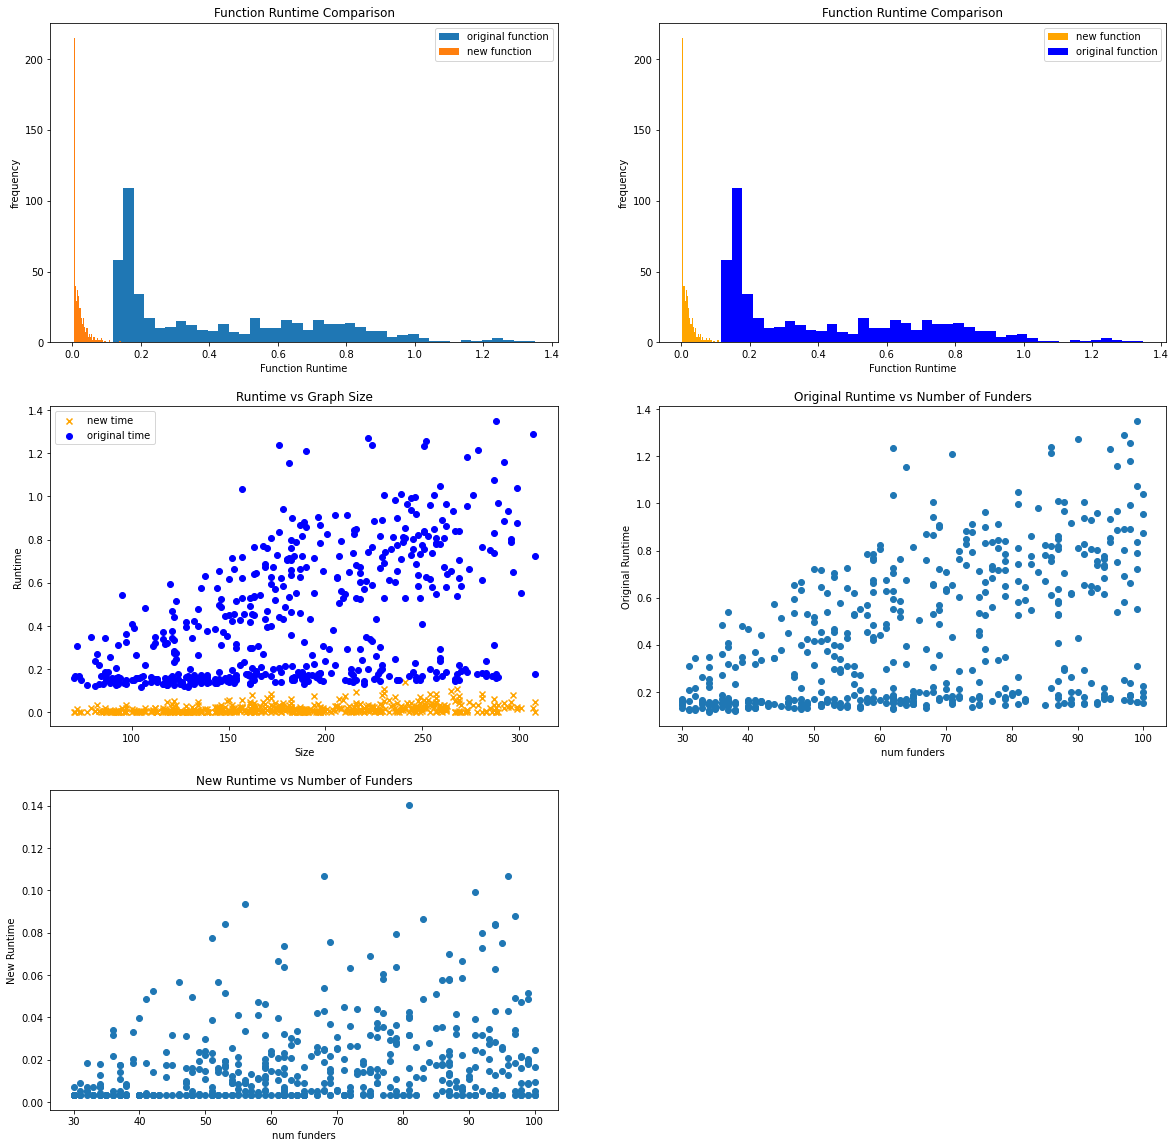

In [ ]:
create_plots(df6)

# Test Suite 7

In this test suite, we will have 500 enteries. Each simulation will have between 2000-3000 funders and 300-500 grants.

In [ ]:
simulations = create_simulations(num_sims = 500, max_funders= 3000, min_funders=2000, max_grants=500, min_grants=300)
df7 = create_times_df(simulations)

In [ ]:
df7.to_csv('./simulations7.csv') 

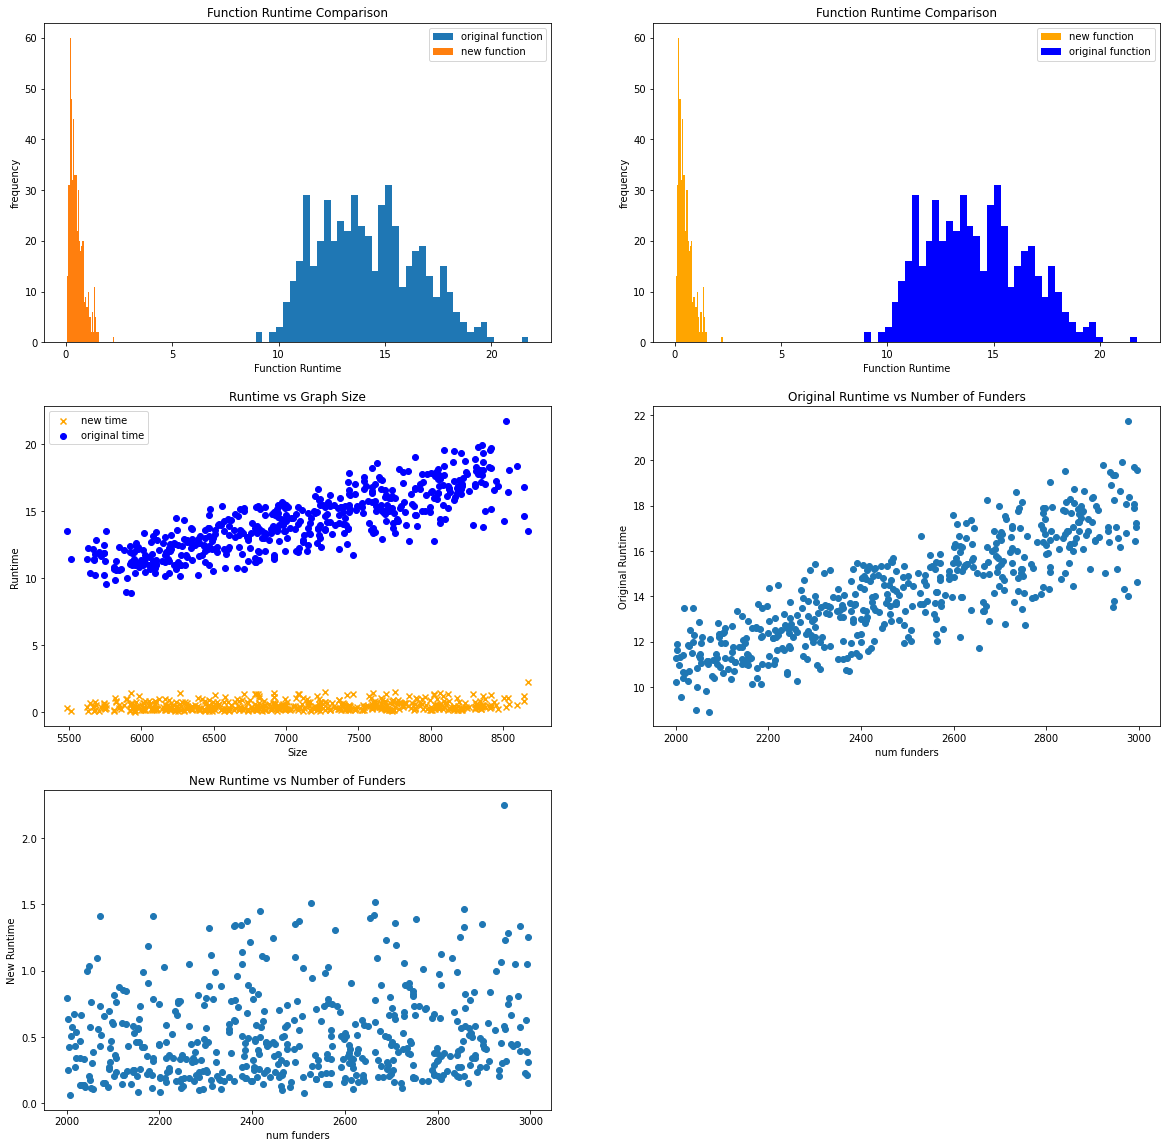

In [ ]:
create_plots(df7)

Echoing the results found in test suite 5, the difference between the two functions is astounding. 

We now offer unit tests for quality assurance purposes. 

In [32]:
import unittest as ut
from networkx.algorithms import bipartite
class TestBipartite(ut.TestCase):
  
    def test_rand_bipartite_creator(self):
      """
      This test case ensures that every graph created by the FundingSimulation
      class is a biparite graph.
      """
        results = []
        for i in range(1,1000):
            set_a_card = randint(1, 1000)
            offset = randint(2,1000)
            set_b_card = randint(set_a_card + 1, set_a_card + offset)
            graph = FundingSimulation(set_a_card, set_b_card).bipart
            result = bipartite.is_bipartite(graph)
            results.append(result)
        condition = False in results
        self.assertFalse(condition)
    
    
    def test_create_simulations(self):
      """
      This test case ensures that every graph created using create_simulations()
      is a biparite graph.
      """
        graphs = create_simulations()
        
        self.assertEqual(len(graphs), 50)
        results = [bipartite.is_bipartite(graph.bipart) for graph in graphs]
        condition = False in results
        self.assertFalse(condition)

    def test_neighbors(self):
      """
      This function tests to ensure that both the original function and the 
      proposed function return the same results. Therefore, the new function
      should be easily integratable.
      """
        simulations = create_simulations(num_sims = 500, max_funders = 30)
        results = []
        for simulation in simulations:
          start_vert = randrange(0, len(simulation.grants))
          G = NeighborsSubgraph(simulation.bipart, start_vert)
          G2 = Neighbors(simulation.bipart, start_vert)
          result = G.nodes == G2.nodes
          result2 = G.edges == G2.edges
          results.append(result)
          results.append(result2)
        condition = False in results
        self.assertFalse(condition)


ut.main(argv=[''], exit=False)

...
----------------------------------------------------------------------
Ran 3 tests in 10.885s

OK
